# Koopman kernel models for TC Tracks

[Work in progress]

In [2]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

In [3]:
from klearn_tcyclone.utils import check_time_steps_TCTracks

### Scaling of time scales

We compare spectral signatures for different basins and time frequencies of the tropical cyclones.

In [4]:
print(f"Basins are given by {BASINS}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


In [86]:
def get_top_k_ev_below_zero(vec: np.ndarray, k: int):
    assert np.ndim(vec) == 1, "'vec' must be a 1D array"
    assert k > 0, "k should be greater than 0"

    eig_below_zero_real = vec[vec.real < 1.0]
    sort_perm = np.flip(np.argsort(eig_below_zero_real.real))  # descending order
    indices = sort_perm[:k]
    values = eig_below_zero_real[indices]
    return values


def train_model(tc_tracks_train, tc_tracks_test, context_length, time_lag, feature_list = ["lat", "lon", "max_sustained_wind"], top_k: int = 5):


    tensor_context_train = context_dataset_from_TCTracks(
        tc_tracks_train, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    tensor_context_test = context_dataset_from_TCTracks(
        tc_tracks_test, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    contexts = {
        "train": tensor_context_train,
        "test": tensor_context_test,
    }
    scaler = LinearScaler()
    tensor_context_train_transformed = standardize_TensorContextDataset(
        tensor_context_train,
        scaler,
        fit=True,
    )
    tensor_context_test_transformed = standardize_TensorContextDataset(
        tensor_context_test,
        scaler,
        fit=False,
    )

    contexts = {
        "train": tensor_context_train_transformed,
        "test": tensor_context_test_transformed,
    }


    ### Spectral analysis
    reduced_rank = True
    rank = 25
    num_centers = 300
    tikhonov_reg = 1e-4

    # Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
    length_scale = 10.0
    kernel = RBF(length_scale=length_scale)
    nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
    nys_rrr = nys_rrr.fit(contexts["train"])


    X_pred = nys_rrr.predict(contexts["test"])  # Here we must pass the `X` part of the context
    X_true = contexts["test"].lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
    rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

    evals = nys_rrr.eig()
    # evals = get_top_k_ev_below_zero(evals, k = top_k)
    # evals = evals[topk(np.abs(evals.real), top_k).indices]
    evals = evals[topk(np.abs(evals), top_k).indices]

    tscales = -1 / np.log(evals.real.clip(1e-8, 1))
    tscales_real = tscales * time_lag

    return rmse_onestep, tscales_real

In [87]:
def time_lag_scaling(basin: str, time_step_h: float, time_lags: list[int], year_range: tuple[int, int] = (2000, 2021), context_length: int =2, top_k: int = 5):
    # Load TCTracks and resample on equal time step.
    tc_tracks = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2021), basin=basin)
    print('Number of tracks:', tc_tracks.size)
    tc_tracks.equal_timestep(time_step_h=time_step_h)
    assert check_time_steps_TCTracks(tc_tracks, time_step_h)

    tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
    feature_list = ["lat", "lon", "max_sustained_wind"]    

    # Train model for varying time_lags.
    error_d = {}
    tscale_d = {}
    for time_lag in time_lags:
        print(f"Train for basin {basin} with time_lag {time_lag}.")
        try:
            error, tscale = train_model(tc_tracks_train, tc_tracks_test, context_length, time_lag, top_k=top_k)
        except:
            error, tscale = None, np.array(top_k * [None])
            print("Not enough time points in some trajectories for given time_lag.")
        error_d[time_lag] = error
        tscale_d[time_lag] = tscale
    
    return error_d, tscale_d

In [89]:
error_d = {}
tscale_d = {}
time_step_h = 3
context_length = 2
# time_lags = range(1, 40, 5)
time_lags = range(1, 30, 2)
basins = BASINS[:-5]
for basin in basins:
    e_d, ts_d = time_lag_scaling(basin, time_step_h, time_lags, context_length=context_length)
    error_d[basin] = e_d
    tscale_d[basin] = ts_d


2024-11-16 12:36:25,499 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-16 12:37:03,879 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 438
Train for basin EP with time_lag 1.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 3.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 5.


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 7.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 9.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 11.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 13.


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 15.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 17.


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 19.


The rank attribute has been updated to 4.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 21.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 23.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 25.


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 27.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin EP with time_lag 29.


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


2024-11-16 12:37:19,016 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Train for basin NA with time_lag 1.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 3.


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 5.


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 7.


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 9.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 11.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 13.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 15.


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 17.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 19.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 21.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 23.


The rank attribute has been updated to 6.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 25.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 27.


The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Train for basin NA with time_lag 29.


The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


RMSE error as a function of the time-lag. The basin is given in the legend.

In [90]:
basins

['EP', 'NA']

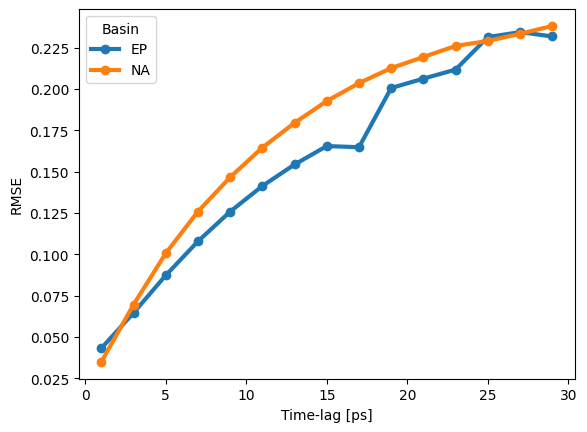

In [91]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

In [92]:
from itertools import product

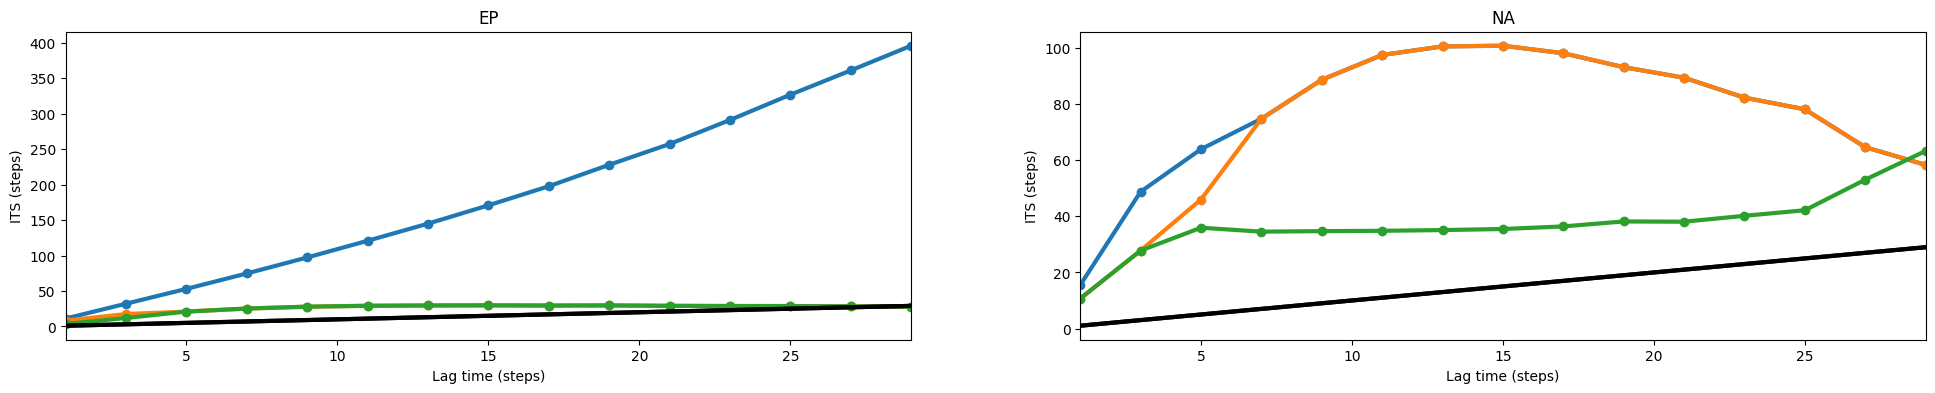

In [94]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

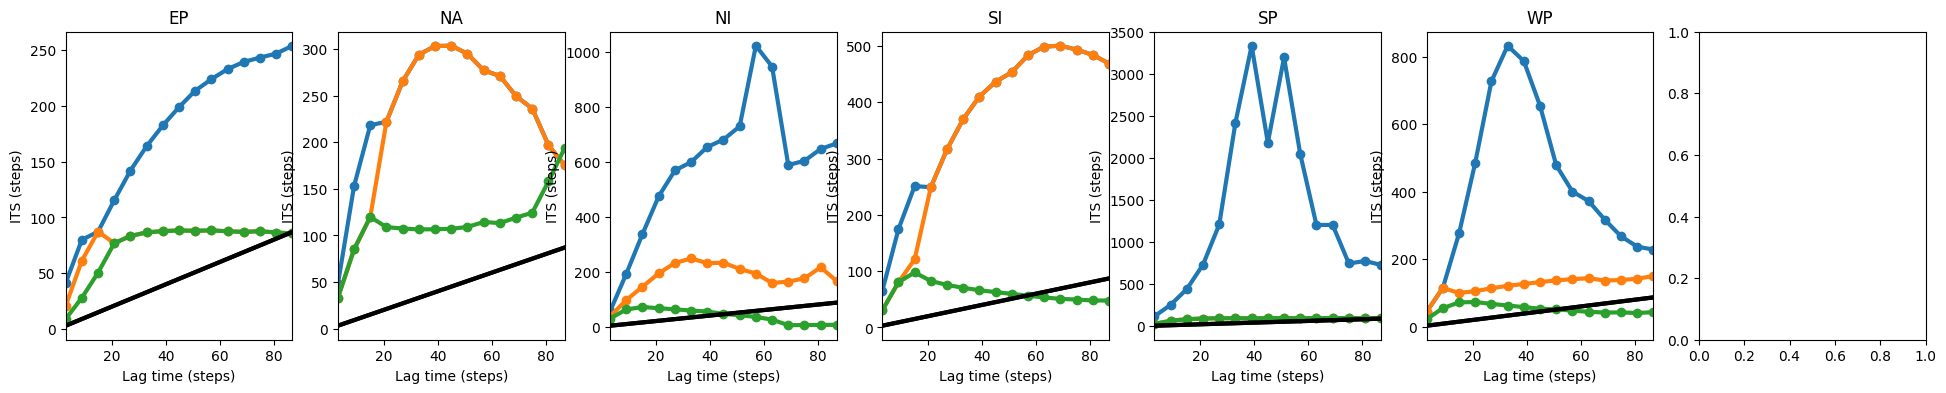

In [112]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

for idx, basin in enumerate(BASINS[:-1]):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

In [ ]:
a = None

In [21]:
len(time_lags)

15

EP
NA
NI
SI
SP
WP


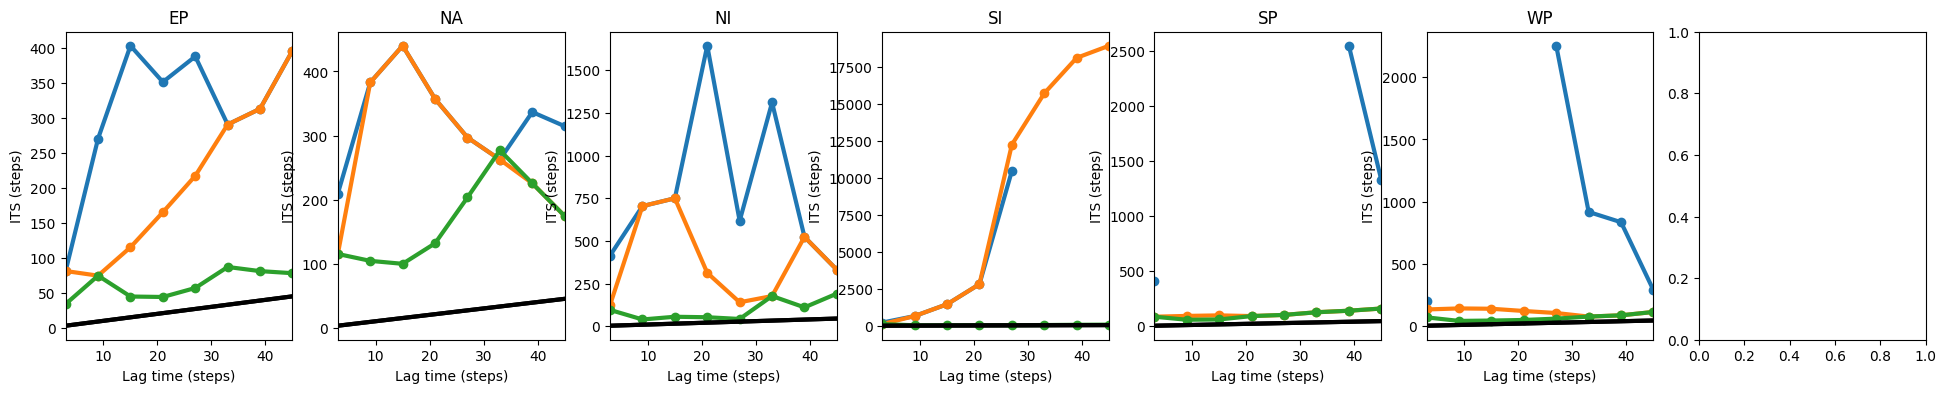

In [26]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

max_time_lag_idx = 8
for idx, basin in enumerate(BASINS[:-1]):

    print(basin)
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[1] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[2] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[3] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')

    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')
    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

#### Plot eigenfunctions along trajectories

In [82]:
test_dataset = contexts["test"]

In [83]:
top_k = 42
evals, evec_right = model.eig(eval_right_on=test_dataset)
top_evals = topk(np.abs(evals), top_k) # Take the Four largest eigenvalues in modulus
evals = evals[top_evals.indices]
evec_right = evec_right[:, top_evals.indices]

In [84]:
evals.shape, evec_right.shape

((18,), (908, 18))

In [85]:
evals

array([ 0.99993099+0.j        ,  0.99810281+0.01789582j,
        0.99810281-0.01789582j,  0.99284253+0.j        ,
        0.96966378+0.j        ,  0.95157093+0.j        ,
        0.92774601+0.j        ,  0.91192916+0.11948172j,
        0.91192916-0.11948172j,  0.84056807+0.17061753j,
        0.84056807-0.17061753j,  0.80860608+0.j        ,
        0.4659339 +0.03439862j,  0.4659339 -0.03439862j,
        0.31285702+0.j        ,  0.08403348+0.j        ,
        0.01126608+0.j        , -0.00254642+0.j        ])

In [86]:
test_dataset.shape

(908, 42, 3)

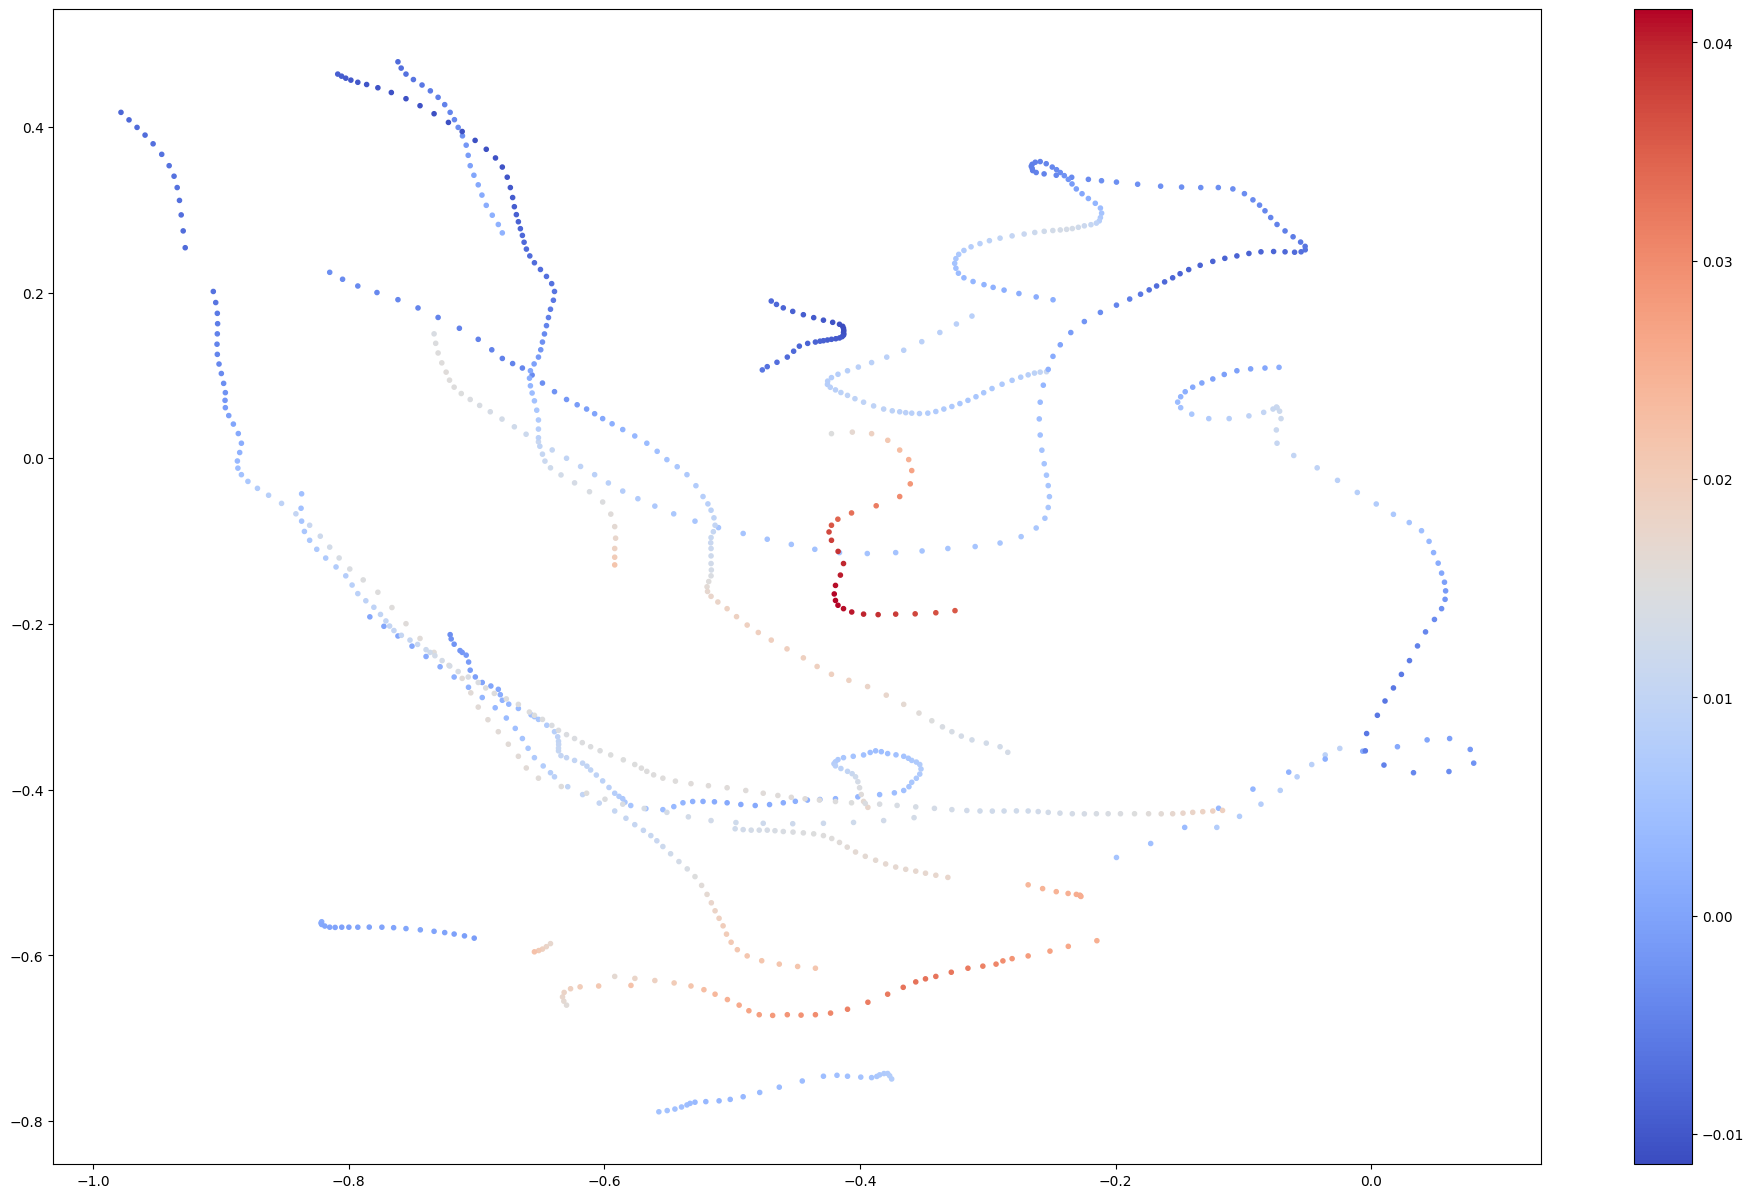

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1
evec_idx = 1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right[:idx, evec_idx])
plt.colorbar()

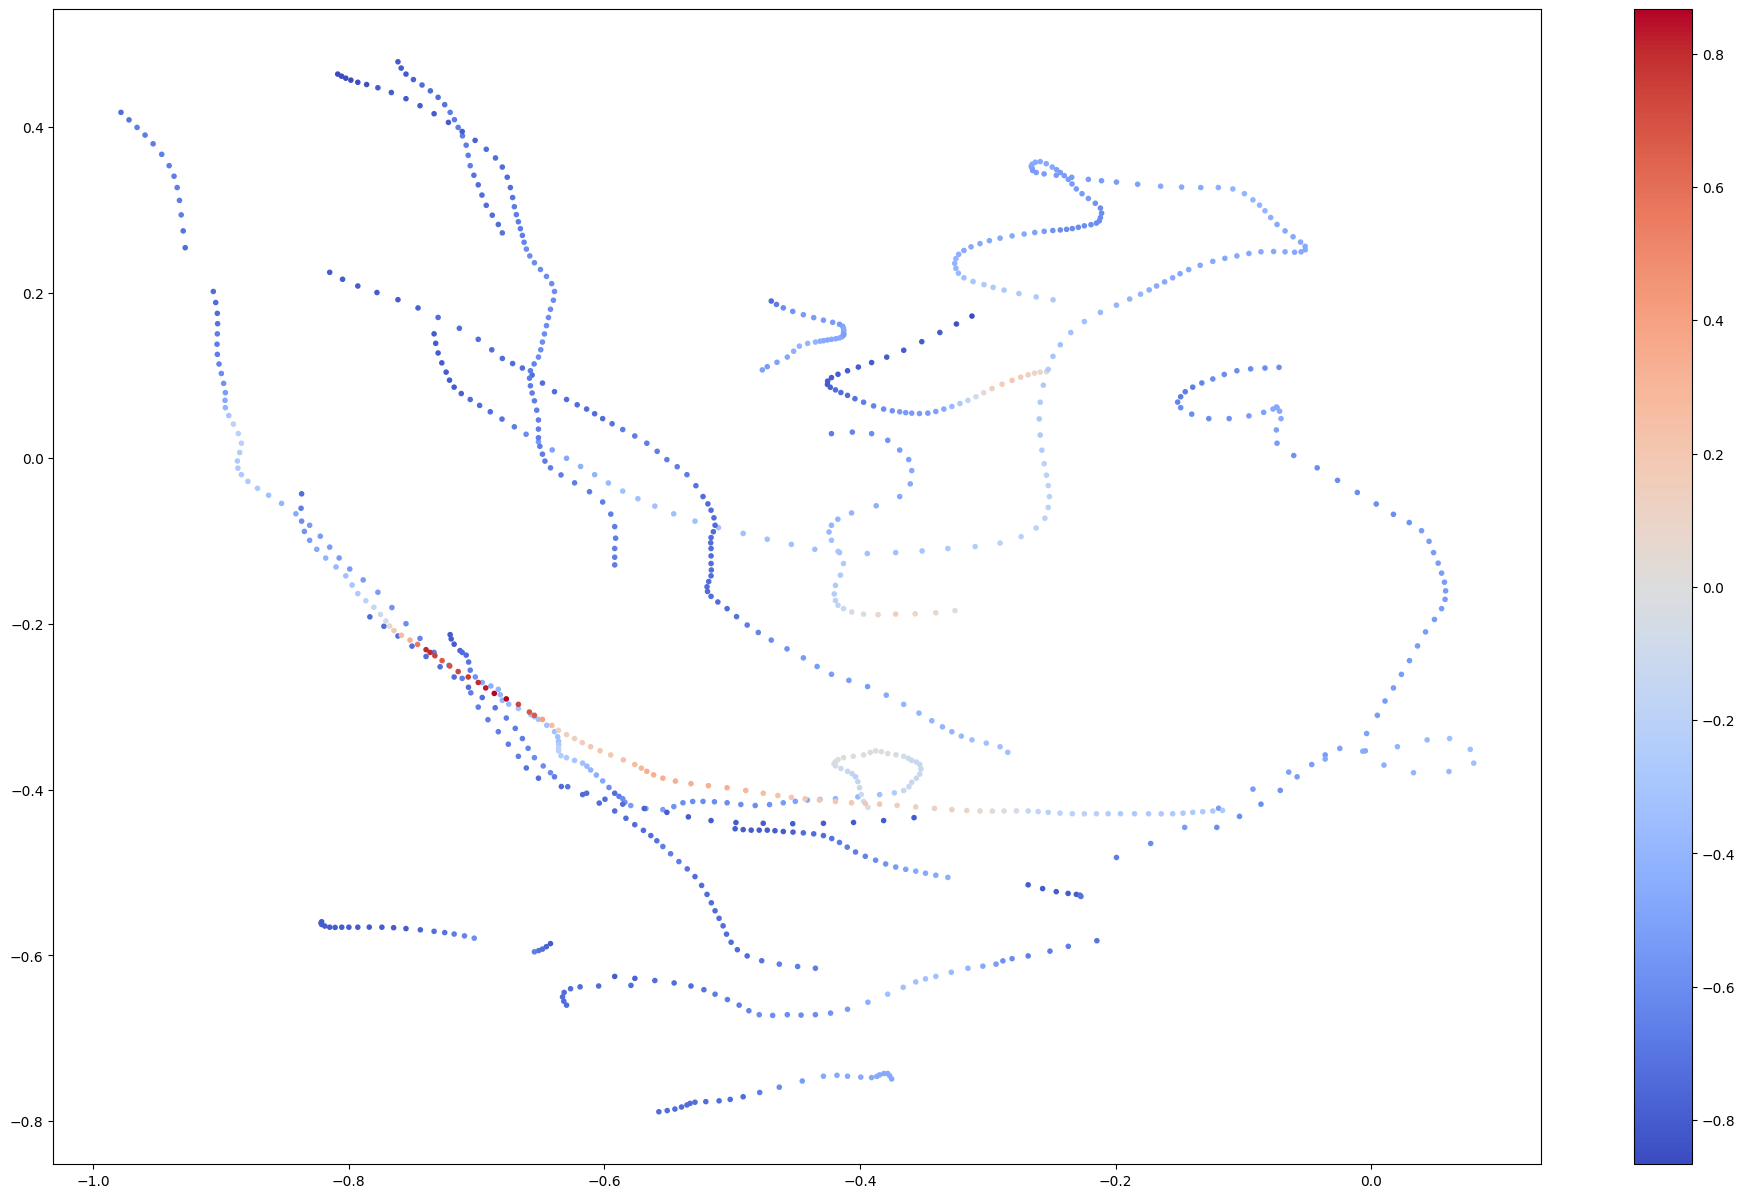

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = test_dataset.data[:idx, 0, 2])
plt.colorbar()